In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
import torchvision.utils as vutils
import itertools

import os
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

# Model

In [2]:
nc = 1
ndf = 64
ngf = 64

class MyModel(nn.Module):
    def __init__(self,latent_dim,nClusters):
        super(MyModel,self).__init__()
        
        self.latent_dim = latent_dim
        self.nClusters = nClusters
        self.pi_=nn.Parameter(torch.FloatTensor(self.nClusters,).fill_(1)/self.nClusters,requires_grad=True)
        self.mu_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        self.log_var_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    #def reparameterize(self, mu, logvar):
        #std = torch.nan_to_num(logvar.mul(0.5).exp_(),nan=0)  ## Reparameterize nan??
        #std = logvar.mul(0.5).exp_()
        #eps = Variable(std.data.new(std.size()).normal_())
          # num = np.array([[ 1.096506  ,  0.3686553 , -0.43172026,  1.27677995,  1.26733758,
          #       1.30626082,  0.14179629,  0.58619505, -0.76423112,  2.67965817]], dtype=np.float32)
          # num = np.repeat(num, mu.size()[0], axis=0)
          # eps = Variable(torch.from_numpy(num))
        #return eps.mul(std).add_(mu)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def gaussian_pdf_log(self,x,mu,log_sigma2):
        return -0.5*(torch.sum(np.log(np.pi*2)+log_sigma2+(x-mu).pow(2)/torch.exp(log_sigma2),1))
    
    def gaussian_pdfs_log(self,x,mus,log_sigma2s):
    #def gaussian_pdfs_log(x,mus,log_sigma2s):
        G=[]
        for c in range(self.nClusters):
            G.append(self.gaussian_pdf_log(x,mus[c:c+1,:],log_sigma2s[c:c+1,:]).view(-1,1))
        return torch.cat(G,1)
    
    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        #decoded = self.decode(mu)
        z = self.reparameterize(mu,logvar)
        z = torch.nan_to_num(z,nan=0)
        #z = torch.randn_like(mu)*torch.exp(logvar/2)+mu
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar
    
    def predict(self,x):
        z_mu, z_sigma2_log = self.encode(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        z = torch.nan_to_num(z,nan=0)
        pi = self.pi_
        log_sigma2_c = self.log_var_c
        mu_c = self.mu_c
        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_sigma2_c))

        yita=yita_c.detach().cpu().numpy()
        #print(yita)
        return np.argmax(yita,axis=1)
        
    def RE(self,recon_x,x):
        return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),size_average=False)

    def KLD(self,mu,log_var):
        det=1e-10

        pi=self.pi_
        log_var_c = self.log_var_c
        mu_c = self.mu_c

        z = torch.randn_like(mu) * torch.exp(log_var/2) + mu
        z = torch.nan_to_num(z,nan=0)

        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_var_c))+det
        yita_c = yita_c/(yita_c.sum(1).view(-1,1))
        loss = 0.5*torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+
                                                    torch.exp(log_var.unsqueeze(1)-log_var_c.unsqueeze(0))+
                                                    (mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))
        loss -= torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+log_var,1))
        return loss

    def loss_function(self,recon_x,x,mu,log_var):
        return self.RE(recon_x,x)+self.KLD(mu,log_var)

# Input Parameter

In [3]:
latent_dim = 10
nClusters = 13
batch = 100

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available else {}

# DataLoader

In [5]:
import h5py

In [6]:
data_list = ['../data/normal_dataset.h5','../data/Anomaly_dataset.h5']

In [7]:
imageList=[]
labelList=[]
for file_path in data_list:
    print('Loading data from ', file_path)
    dataset = h5py.File(file_path,'r',libver='latest',swmr=True)
    FimageList=[]
    FlabelList=[]
    for gName,group in dataset.items():
        for dName,data in group.items():
            if dName == 'images':
                FimageList.append(data)
            elif dName == 'labels':
                FlabelList.append(data)

    if len(FimageList) >= 2:
        #print("More than 2 gropus in File")
        image_concat = []
        for i in range(0,len(FimageList)):
            image_concat.append(FimageList[i][:])
        imageList.append(np.concatenate(image_concat))
        label_concat = []
        for i in range(0,len(FlabelList)):
            label_concat.append(FlabelList[i][:])
        labelList.append(np.concatenate(label_concat))
    else:
        imageList.append(FimageList[0][:])
        labelList.append(FlabelList[0][:])
imageList = np.concatenate(imageList)
labelList = np.concatenate(labelList)
print('input image shape : ',imageList.shape)
print('input label shape : ',labelList.shape)
ds = TensorDataset(torch.tensor(imageList),torch.tensor(labelList))
length = [int(len(ds)*0.7),int(len(ds)*0.2)]
length.append(len(ds)-sum(length))

trnSet,valSet,tstSet=torch.utils.data.random_split(ds,length)

#train Loader
train_loader = DataLoader(trnSet, batch_size=batch, shuffle=True, **kwargs)
#test Loader
test_loader = DataLoader(valSet, batch_size=batch, shuffle=False, **kwargs)

Loading data from  ../data/normal_dataset.h5
Loading data from  ../data/Anomaly_dataset.h5
input image shape :  (72100, 1, 28, 28)
input label shape :  (72100,)


# Initial $\gamma$-training

In [8]:
# Initial gamma-training parameter
gamma = 1e-5
gamma_step = 200

In [9]:
def gamma_training(gamma,steps,dataloader):
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    print('Starting initial gamma training for ',steps,'steps.')
    for batch_idx, (data,_) in tqdm(enumerate(train_loader)):

        #print(batch_idx+1,'step trained')
        data = Variable(data)
        data = data.cuda()
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = model.RE(recon_batch,data) + gamma * model.KLD(mu,logvar)
        loss.backward()
        #print(loss.item())
        optimizer.step()
        
        if batch_idx +1 == steps:
            print('Training completed')
            break

In [10]:
net = MyModel(latent_dim=latent_dim,nClusters=nClusters)

In [11]:
model = net.cuda()

In [12]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
                      0.0769, 0.0769, 0.0769, 0.0769], device='cuda:0')),
             ('mu_c',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                     

In [13]:
gamma_training(gamma=gamma,steps=gamma_step,dataloader=train_loader)

Starting initial gamma training for  200 steps.


0it [00:00, ?it/s]C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
199it [00:13, 14.36it/s]


Training completed


In [14]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.2307, 0.2307, 0.2307, 0.2307, 0.2307, 0.2307, 0.2307, 0.2307, 0.2307,
                      0.2307, 0.2307, 0.2307, 0.2307], device='cuda:0')),
             ('mu_c',
              tensor([[ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
                        0.2326,  0.2382],
                      [ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
                        0.2326,  0.2382],
                      [ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
                        0.2326,  0.2382],
                      [ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
                        0.2326,  0.2382],
                      [ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
                        0.2326,  0.2382],
                      [ 0.2058,  0.2355, -0.2284, -0.2255, -0.2397, -0.2063,  0.2387, -0.2159,
         

# mini-Batch GMM initialization

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
k=round(len(train_loader)/2)

In [16]:
subset = np.random.randint(len(train_loader),size=k*batch)

In [17]:
train_subset_loader = DataLoader(torch.utils.data.Subset(trnSet,subset))

In [18]:
Z=[]
Y=[]
print('GMM Initializing with ',k*batch, 'MC samples')
with torch.no_grad():
    for batch_idx, (data,y) in tqdm(enumerate(train_subset_loader)):
        data = data.cuda()
        
        mu,logvar = model.encode(data)
        
        #assert nn.functional.mse_loss(mu,logvar)==0
        Z.append(mu)
        Y.append(y)
    Z=torch.cat(Z,0).detach().cpu().numpy()
    Y=torch.cat(Y,0).detach().cpu().numpy()
    
    kmeans = KMeans(n_clusters=nClusters, random_state=0)
    kmeans.fit(Z)
    
    #model.mu_c.data = torch.from_numpy(kmeans.cluster_centers).cuda().float()
    
    gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04),means_init = kmeans.cluster_centers_,random_state=100)
    #gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04))
    
    pre = gmm.fit_predict(Z)
    
    model.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
    model.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
    model.log_var_c.data = torch.log(torch.from_numpy(gmm.covariances_).cuda().float())

GMM Initializing with  25200 MC samples


25200it [00:28, 890.70it/s]


In [19]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0955, 0.1154, 0.0703, 0.1396, 0.0371, 0.0042, 0.1330, 0.0625, 0.0784,
                      0.0702, 0.1056, 0.0264, 0.0618], device='cuda:0')),
             ('mu_c',
              tensor([[  7.9506,  19.9088, -27.3837, -32.0601, -16.5176,  -8.8134,  18.0087,
                       -15.4909,  17.0349,  22.9894],
                      [  7.4663,  17.6940, -24.2890, -27.8078, -15.0283,  -8.2192,  16.2808,
                       -14.1093,  15.2418,  20.4738],
                      [  7.1345,  15.9835, -21.7892, -24.1118, -14.1565,  -7.8011,  15.1594,
                       -13.1253,  13.9461,  18.4994],
                      [  7.7752,  18.6734, -25.6253, -29.4629, -15.8624,  -8.5913,  17.1056,
                       -14.8324,  16.0399,  21.5159],
                      [  8.4372,  22.2549, -30.6845, -36.5196, -18.0317,  -9.4585,  19.8806,
                       -16.9392,  18.9700,  25.7347],
                      [  5.5814,  13.1612, -17.7259, -

# Periodic $\beta$ - Annealing

In [20]:
n_iter = len(train_loader)
n_cycle = 5
ratio = 0.5
start = gamma
stop = gamma + 1

L = np.ones(n_iter)
period = n_iter/n_cycle
step = (stop-start)/(period*ratio)

for c in range(n_cycle):
    v, i = start, 0
    while v<= stop and (int(i+c*period)<n_iter):
        L[int(i+c*period)]=v
        v += step
        i += 1

# Inverse Min-Max Transform : Avoid NaN Losses

# Test Training

In [21]:
epochs = 300
batch_size = 100 
optimizer=optim.Adam(model.parameters())
outf = './test'

In [22]:
def train(epoch):
    model.train()
    #print('train')
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        #print(data.shape)
        #print(data)
        if torch.cuda.is_available():
            data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        
        beta = L[batch_idx]
        
        #print(recon_batch.shape,mu.shape,logvar.shape)
        #print(recon_batch.view(-1,784))
        #print(recon_batch.shape)
        #print(recon_batch)
        #print(data.shape)
        #print(model.RE(recon_batch,data))
        #print(model.KLD(mu,logvar))
        loss = model.RE(recon_batch,data) + beta * model.KLD(mu,logvar)
        
        #loss = model.loss_function(recon_batch,data,mu,logvar)
        
        if np.isnan(loss.data.cpu().item()):
        #if np.isnan(loss.data.item()):
            break
            print('NaN Loss!')
            print('RE : ',model.RE(recon_batch,data)/len(recon_batch))
            print('KL-D : ',model.KLD(mu,logvar))
        
        else:
            loss.backward()
            #print(loss.data.item())
            train_loss += loss.data
            #print(loss.data)
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.data / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    #if epoch % 5 == 0:
        #torch.save(model.state_dict(),'./model_%d.pth' % (epoch))
    #return (train_loss/len(train_loader.dataset)).cpu()
    return train_loss/len(train_loader.dataset)

In [23]:
def test(epoch):
    model.eval()
    #print('validation')
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).data
        if i == 0:
            n = min(data.size(0), 16)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss.cpu()
    #return test_loss

In [24]:
best_=100
best_epoch=0
train_loss_arr=[]
test_loss_arr=[]
for epoch in range(1,epochs+1):
    train_loss_arr.append(train(epoch).cpu().numpy())
    val_loss = test(epoch)
    test_loss_arr.append(val_loss.cpu().numpy())
    if val_loss.cpu() < best_:
    #if val_loss < best_:
        best_=val_loss.cpu()
        #best_ = val_loss
        best_epoch = epoch
        print('Save model at epoch ',best_epoch,' Validation Loss : ',best_.item())
        torch.save(model.state_dict(),'./s3vdc_test4_5.pth')
    
    if np.isnan(val_loss.cpu()): 
        break
print("Model is saved at epoch ",best_epoch," | Validation Loss : ",best_.item(),"Saved path : ./s3vdc_4_5.pth")

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50470 (0%)]	Loss: 197.800720
Train Epoch: 1 [10000/50470 (20%)]	Loss: 177.590622
Train Epoch: 1 [20000/50470 (40%)]	Loss: 154.196976
Train Epoch: 1 [30000/50470 (59%)]	Loss: 141.488098
Train Epoch: 1 [40000/50470 (79%)]	Loss: 141.481461
Train Epoch: 1 [50000/50470 (99%)]	Loss: 116.070351
====> Epoch: 1 Average loss: 156.1875


C:\Users\jysin\AppData\Local\Temp/ipykernel_11704/3391578916.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


====> Test set loss: 132.2284
Train Epoch: 2 [0/50470 (0%)]	Loss: 128.562683
Train Epoch: 2 [10000/50470 (20%)]	Loss: 109.128532
Train Epoch: 2 [20000/50470 (40%)]	Loss: 110.362656
Train Epoch: 2 [30000/50470 (59%)]	Loss: 116.227791
Train Epoch: 2 [40000/50470 (79%)]	Loss: 105.262177
Train Epoch: 2 [50000/50470 (99%)]	Loss: 97.220314
====> Epoch: 2 Average loss: 108.7588
====> Test set loss: 116.3436
Train Epoch: 3 [0/50470 (0%)]	Loss: 91.476189
Train Epoch: 3 [10000/50470 (20%)]	Loss: 95.519958
Train Epoch: 3 [20000/50470 (40%)]	Loss: 95.752007
Train Epoch: 3 [30000/50470 (59%)]	Loss: 90.458084
Train Epoch: 3 [40000/50470 (79%)]	Loss: 94.743652
Train Epoch: 3 [50000/50470 (99%)]	Loss: 97.373047
====> Epoch: 3 Average loss: 94.8642
====> Test set loss: 95.0301
Save model at epoch  3  Validation Loss :  95.03009033203125
Train Epoch: 4 [0/50470 (0%)]	Loss: 88.552414
Train Epoch: 4 [10000/50470 (20%)]	Loss: 92.654968
Train Epoch: 4 [20000/50470 (40%)]	Loss: 88.219292
Train Epoch: 4 [3000

====> Epoch: 21 Average loss: 70.4861
====> Test set loss: 73.6472
Save model at epoch  21  Validation Loss :  73.64723205566406
Train Epoch: 22 [0/50470 (0%)]	Loss: 66.947052
Train Epoch: 22 [10000/50470 (20%)]	Loss: 74.097816
Train Epoch: 22 [20000/50470 (40%)]	Loss: 70.292900
Train Epoch: 22 [30000/50470 (59%)]	Loss: 68.805351
Train Epoch: 22 [40000/50470 (79%)]	Loss: 65.650444
Train Epoch: 22 [50000/50470 (99%)]	Loss: 74.213158
====> Epoch: 22 Average loss: 70.0960
====> Test set loss: 73.2733
Save model at epoch  22  Validation Loss :  73.27334594726562
Train Epoch: 23 [0/50470 (0%)]	Loss: 63.320904
Train Epoch: 23 [10000/50470 (20%)]	Loss: 71.389084
Train Epoch: 23 [20000/50470 (40%)]	Loss: 72.974098
Train Epoch: 23 [30000/50470 (59%)]	Loss: 71.178780
Train Epoch: 23 [40000/50470 (79%)]	Loss: 72.549568
Train Epoch: 23 [50000/50470 (99%)]	Loss: 72.149284
====> Epoch: 23 Average loss: 69.7171
====> Test set loss: 73.2557
Save model at epoch  23  Validation Loss :  73.25572204589844

In [25]:
model.state_dict()

OrderedDict([('pi_',
              tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                     device='cuda:0')),
             ('mu_c',
              tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
               

In [26]:
model.load_state_dict(torch.load('./s3vdc_test4_5.pth'))

<All keys matched successfully>

In [27]:
model.state_dict()

OrderedDict([('pi_',
              tensor([12.8137, 12.9427,  9.7208, 13.0583, 12.2897, 11.3973, 12.9797, 12.6097,
                      12.1315, 12.3134, 12.7750,  7.3402, 12.5965], device='cuda:0')),
             ('mu_c',
              tensor([[  7.1426,  15.4861, -21.9179, -24.7390, -13.2370,  -7.7386,  13.5634,
                       -14.0962,  14.9281,  19.2709],
                      [  7.0958,  15.3233, -20.8007, -21.9068, -13.1970,  -7.7050,  13.3752,
                       -14.0538,  15.0813,  19.3089],
                      [  6.9912,  15.5066, -21.0835, -22.2296, -13.4598,  -7.6613,  14.1255,
                       -13.6844,  14.8686,  19.5085],
                      [  7.0047,  15.2738, -21.1145, -22.8787, -13.2351,  -7.6894,  13.3521,
                       -13.9582,  15.1065,  19.2636],
                      [  6.8963,  16.2294, -23.6248, -28.2240, -13.5480,  -7.5185,  14.2202,
                       -14.0276,  15.4319,  20.4793],
                      [  7.2004,  15.0337

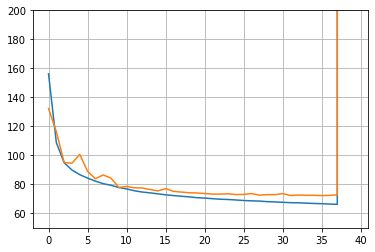

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr)
plt.plot(test_loss_arr)
plt.ylim(50,200)
plt.grid()
plt.show()

In [29]:
t_im,t_la = next(iter(test_loader))
t_imc = t_im.cuda()
t_re,t_mu_,t_logvar = model(t_imc)
t_mu2,t_logvar2 = model.encode(t_im.cuda())
t_z = model.reparameterize(t_mu2,t_logvar2)
t_re2 = model.decode(t_z)

In [30]:
len(t_re)

100

In [31]:
#(model.RE(t_re,t_imc)/len(t_re))+model.KLD(t_mu_,t_logvar)
model.RE(t_re,t_imc)/len(t_re)
#model.KLD(t_mu_,t_logvar)

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(72.2234, device='cuda:0', grad_fn=<DivBackward0>)

In [32]:
t_la[0]

tensor(7., dtype=torch.float64)

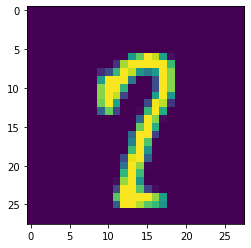

In [33]:
plt.imshow(t_im[0][0][:])

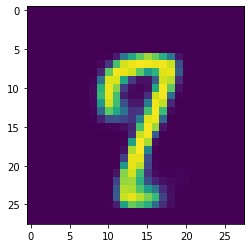

In [34]:
plt.imshow(t_re[0][0][:].detach().cpu().numpy())

# Prediction Test

In [35]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [36]:
x_1[0][0].shape

torch.Size([1, 28, 28])

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


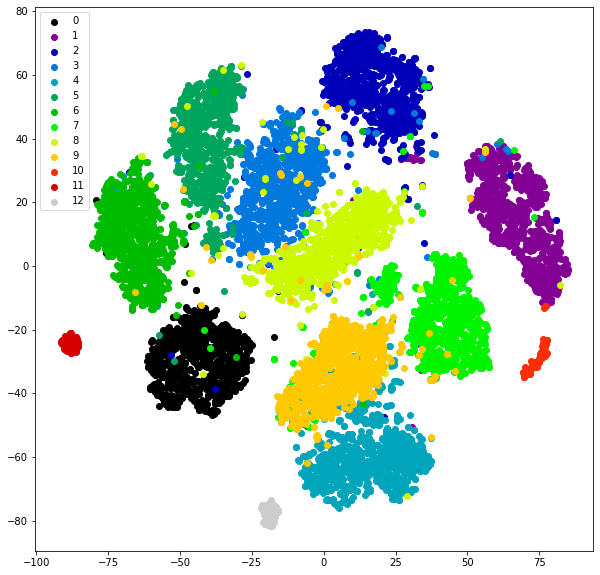

In [37]:
from sklearn.manifold import TSNE
x_t = torch.cat(x_1[:100])
y_t = torch.cat(y_1[:100])
recon,mu,logvar = model(x_t.cuda())
z = model.reparameterize(mu,logvar).detach().cpu().numpy()

tsne = TSNE(n_components=2)
tsneArr = tsne.fit_transform(z)

c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(y_t)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(y_t))):
    plt.scatter(tsneArr[y_t==i,0],tsneArr[y_t==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')